In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from scipy.optimize import linprog
from sklearn.metrics import accuracy_score

class LocalSimplicialInterpolator:
    def __init__(self, k_neighbors=30):
        """
        k_neighbors: How many local points to consider when trying to find an 
                     enclosing simplex. Must be > dimensionality.
        """
        self.k = k_neighbors
        self.X_train = None
        self.y_train = None
        self.nbrs = None
        self.classes_ = None

    def fit(self, X, y):
        self.X_train = X
        self.classes_ = np.unique(y)
        self.y_train = np.eye(len(self.classes_))[y]
        
        self.nbrs = NearestNeighbors(n_neighbors=self.k, algorithm='auto').fit(X)
        return self

    def predict(self, X_test):
        n_samples = X_test.shape[0]
        n_classes = len(self.classes_)
        y_pred = np.zeros(n_samples)
        
        inside_hull_count = 0
        
        _, indices_all = self.nbrs.kneighbors(X_test)
        
        print(f"Processing {n_samples} test points (solving LP for each)...")
        
        for i in range(n_samples):

            local_indices = indices_all[i]
            X_local = self.X_train[local_indices]  # Shape (k, d)
            y_local = self.y_train[local_indices]  # Shape (k, n_classes)
            x_target = X_test[i]
            
            c = np.zeros(self.k) 
            
            
            A_eq = np.vstack([X_local.T, np.ones((1, self.k))])
            b_eq = np.concatenate([x_target, [1.0]])
            
            res = linprog(c, A_eq=A_eq, b_eq=b_eq, bounds=(0, None), method='highs')
            
            if res.success:
                weights = res.x
                pred_probs = weights @ y_local
                y_pred[i] = np.argmax(pred_probs)
                inside_hull_count += 1
            else:
                y_pred[i] = -1 

        coverage_pct = (inside_hull_count / n_samples) * 100
        print(f"\nCompleted. Simplicial Coverage: {coverage_pct:.2f}% of test points were inside a hull.")
        return y_pred



Reducing dimensions to 7 (Required for Simplex coverage)...
Training on 63000 samples with 20.0% label noise.
Processing 7000 test points (solving LP for each)...

Completed. Simplicial Coverage: 21.81% of test points were inside a hull.

Accuracy on Covered Points: 78.19%


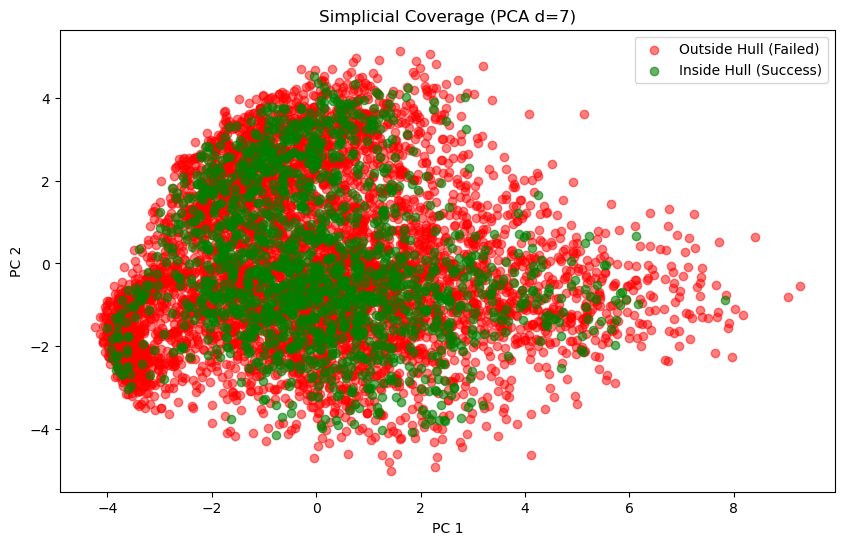

In [3]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
X = X
y = y.astype(int)
X = X / 255.0

pca_dims = 7
print(f"Reducing dimensions to {pca_dims} (Required for Simplex coverage)...")
pca = PCA(n_components=pca_dims)
X_pca = pca.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.1, random_state=42)

noise_level = 0.20
n_train = len(y_train)
n_noise = int(noise_level * n_train)
noise_indices = np.random.choice(n_train, n_noise, replace=False)
y_train_noisy = y_train.copy()
for idx in noise_indices:
    current_label = y_train[idx]
    possible = list(range(10))
    possible.remove(current_label)
    y_train_noisy[idx] = np.random.choice(possible)

print(f"Training on {len(y_train)} samples with {noise_level*100}% label noise.")

model = LocalSimplicialInterpolator(k_neighbors=pca_dims * 3) # Look at 3x dim neighbors
model.fit(X_train, y_train_noisy)
preds = model.predict(X_test)

valid_mask = preds != -1
if np.sum(valid_mask) > 0:
    acc = accuracy_score(y_test[valid_mask], preds[valid_mask])
    print(f"\nAccuracy on Covered Points: {acc*100:.2f}%")
else:
    print("\nAccuracy: N/A (No points inside convex hull)")

plt.figure(figsize=(10, 6))
plt.scatter(X_test[~valid_mask, 0], X_test[~valid_mask, 1], c='red', alpha=0.5, label='Outside Hull (Failed)')
plt.scatter(X_test[valid_mask, 0], X_test[valid_mask, 1], c='green', alpha=0.6, label='Inside Hull (Success)')
plt.title(f"Simplicial Coverage (PCA d={pca_dims})")
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.legend()
plt.show()

Loading MNIST (subset)...
Train size: 59500, Test size: 300
Running Experiment on MNIST for d=[3, 4, 5, 6, 7, 8]...

--- Dimension 3 ---
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 79.67% of test points were inside a hull.

--- Dimension 4 ---
Processing 300 test points (solving LP for each)...

Completed. Simplicial Coverage: 67.00% of test points were inside a hull.
Processing 300 test points (solving LP for each)...

Completed. Simplicial Cover

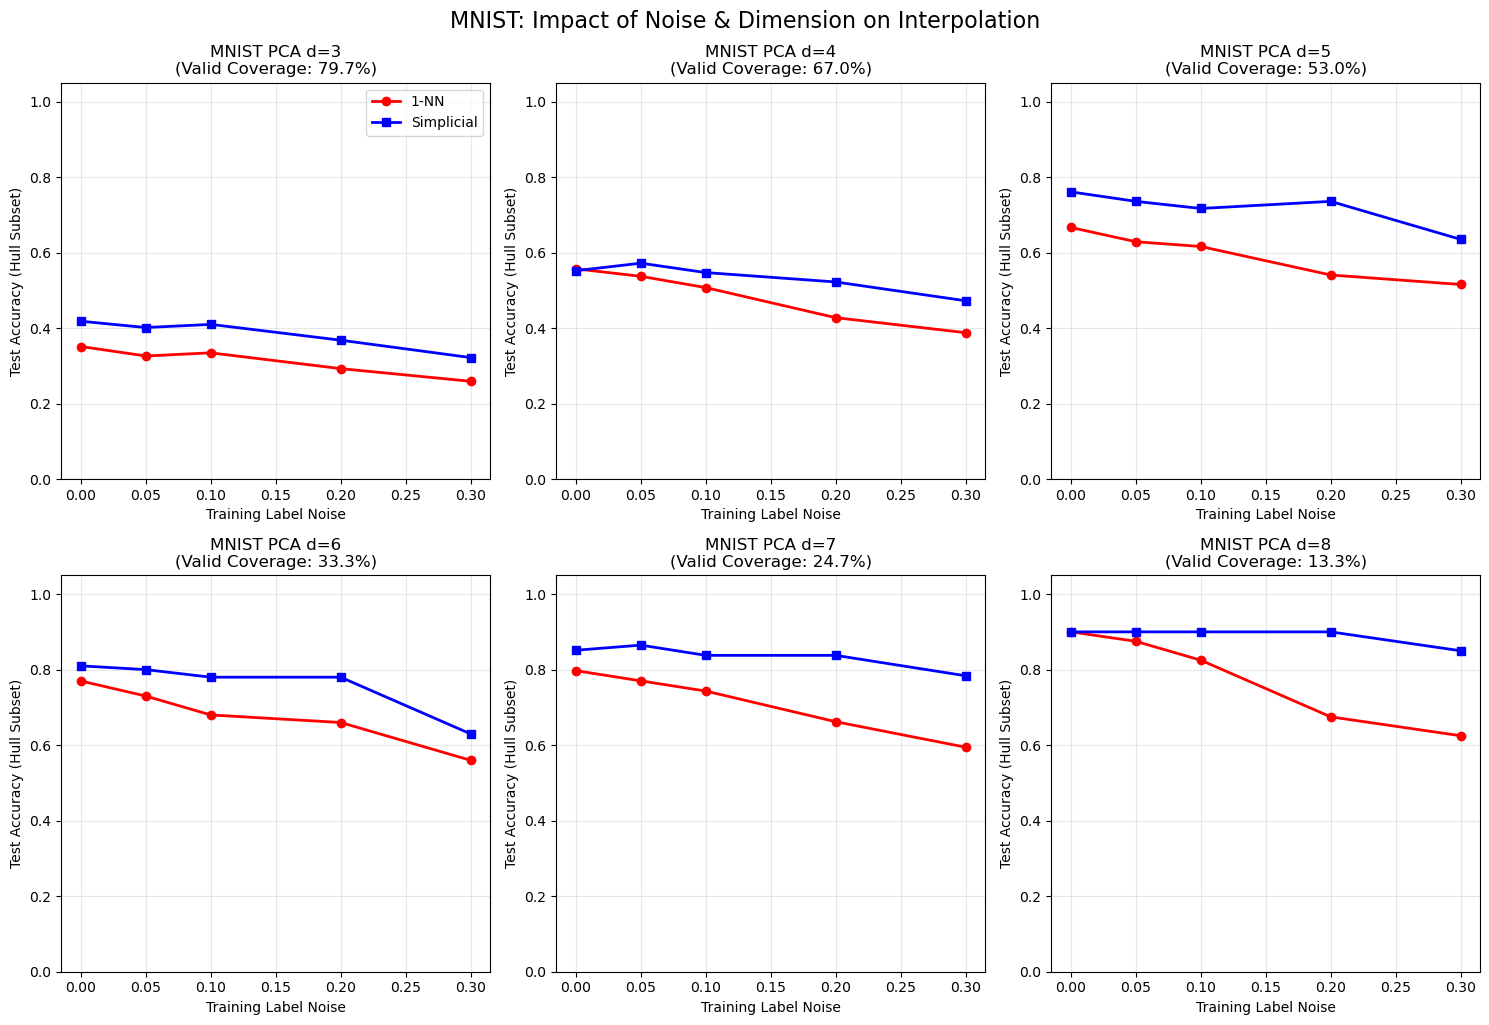

In [8]:
print("Loading MNIST (subset)...")
X_raw, y_raw = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

y_raw = y_raw.astype(int)

# Split first, then we will PCA inside the loop
X_tr_raw, X_te_raw, y_tr, y_te = train_test_split(X_raw, y_raw, test_size=0.15, random_state=42)

# Limit test set size for the Simplicial loop (Linear Programming is CPU heavy)
X_te_raw = X_te_raw[:300]
y_te = y_te[:300]

print(f"Train size: {len(y_tr)}, Test size: {len(y_te)}")


d_values = range(3, 9) # Dimensions 3 to 8
noise_levels = [0.0, 0.05, 0.1, 0.2, 0.3]

# Store results for plotting
plot_data = {} 

print(f"Running Experiment on MNIST for d={list(d_values)}...")

for d in d_values:
    print(f"\n--- Dimension {d} ---")
    
    # Apply PCA for this specific dimension
    pca = PCA(n_components=d)
    X_train = pca.fit_transform(X_tr_raw)
    X_test = pca.transform(X_te_raw)
    
    # Store metrics for this d
    accs_1nn = []
    accs_lsi = []
    coverages = []
    
    # Scale k neighbors relative to d (heuristic: 3*d usually gives enough hull candidates)
    k_simplicial = d * 3
    
    for noise in noise_levels:
        # A. Inject Noise
        y_train_noisy = y_tr.copy()
        n_noise = int(noise * len(y_tr))
        
        if n_noise > 0:
            noise_idx = np.random.choice(len(y_tr), n_noise, replace=False)
            random_shift = np.random.randint(1, 10, size=n_noise)
            y_train_noisy[noise_idx] = (y_train_noisy[noise_idx] + random_shift) % 10
            
        # B. Train Models
        # 1-NN
        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(X_train, y_train_noisy)
        
        # Simplicial
        lsi = LocalSimplicialInterpolator(k_neighbors=k_simplicial)
        lsi.fit(X_train, y_train_noisy)
        
        # C. Predict
        pred_1nn = knn.predict(X_test)
        pred_lsi = lsi.predict(X_test)
        
        # D. Evaluate ONLY on valid hull points
        valid_mask = pred_lsi != -1
        n_valid = np.sum(valid_mask)
        coverage_pct = n_valid / len(y_te)
        
        if n_valid > 0:
            score_1nn = accuracy_score(y_te[valid_mask], pred_1nn[valid_mask])
            score_lsi = accuracy_score(y_te[valid_mask], pred_lsi[valid_mask])
        else:
            score_1nn = np.nan # No data to compare
            score_lsi = np.nan
            
        accs_1nn.append(score_1nn)
        accs_lsi.append(score_lsi)
        
        if noise == 0.0: # Print coverage once per dimension
             coverages.append(coverage_pct) # store for title
             
        # Optional: Print progress line
        # print(f"  Noise {noise*100:.0f}% -> Cov: {coverage_pct:.1%} | 1NN: {score_1nn:.3f} LSI: {score_lsi:.3f}")

    plot_data[d] = {
        'noise': noise_levels,
        '1nn': accs_1nn,
        'lsi': accs_lsi,
        'avg_cov': np.mean(coverages) if coverages else 0
    }

# ==========================================
# 4. PLOTTING RESULTS
# ==========================================


fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, d in enumerate(d_values):
    ax = axes[i]
    data = plot_data[d]
    
    # Plot lines
    ax.plot(data['noise'], data['1nn'], 'r-o', label='1-NN', linewidth=2)
    ax.plot(data['noise'], data['lsi'], 'b-s', label='Simplicial', linewidth=2)
    
    # Formatting
    ax.set_title(f"MNIST PCA d={d}\n(Valid Coverage: {data['avg_cov']:.1%})")
    ax.set_xlabel("Training Label Noise")
    ax.set_ylabel("Test Accuracy (Hull Subset)")
    ax.set_ylim(0, 1.05)
    ax.grid(True, alpha=0.3)
    
    # Handle NaN cases (if coverage was 0)
    if np.isnan(data['lsi']).all():
        ax.text(0.5, 0.5, "Coverage = 0%\nCannot Evaluate", 
                ha='center', va='center', transform=ax.transAxes, color='red')
    
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.suptitle("MNIST: Impact of Noise & Dimension on Interpolation", y=1.02, fontsize=16)
plt.show()